# Using the Power Method and the Frank-Wolfe Method for Stable Matrix Completion

This code uses the Frank-Wolfe method to solve the matrix completion problem analogous to the famous Netflix problem.

In [1]:
import numpy as np

from pdb import set_trace

import matplotlib.pyplot as plt
%matplotlib inline 

In [8]:
# Implementation of Power method for singular vector computation
def PM(A, ninner=100, eps=1e-6):
    '''
    Input: 
        A:     Matrix of interest (M by N)
        niter: Maximum number of iterations
        eps:   Tolerance 
    Intermediate: 
        N:     Number of columns of A
    Output: 
        u1:  1st left singular vector 
        v1:  1st right singular vector
        itr: Number of Iterations requires 
    '''   
     # Initialize v1
    n = A.shape[1]
    v1 = np.ones((n,1))
    out_v = [v1]
    
    # Matrix to determine v1
    N = A.T @ A

    for itr in range(ninner):
        # Power Method
        
        # v1 = [V]v1 / ||[V]v1||_2
        _v = N @ v1
        v1 = _v / np.linalg.norm(_v)
        out_v.append(v1)
        
        # Stopping crieterion ||v_{k+1} - v_k||/ ||v_k|| < eps
        if (np.linalg.norm(out_v[itr+1] - out_v[itr]) / np.linalg.norm(out_v[itr]) < eps):
            # compute u1 = A v_1 / ||A v_1||
            _u = A@ v1
            u1 = _u / np.linalg.norm(_u)
            return u1, v1, itr+1
            
    return u1, v1, itr+1

## Stable Matrix Completion Problem

Solving the Stable Matrix Completion Problem: 

$$\underset{\{\mathbf{X}:\|\mathbf{X}\|_{*}\leq \tau\}}{\min} \frac{1}{2} \|P_{\Omega}[\mathbf{X}-Y]\|_F^2$$

In [9]:
def FW(Z, Mk, Data, t=1, fun=lambda z:0, niter=100, pmiter = 100, eps=1e-6):
    '''
    Input: 
        Z:      Matrix
        Mk:     Mask Matrix
        Data:   Data Matrix
        t:      Constrain parameter (i.e upper bound on Nuclear Norm of Z)
        niter:  Number of iterations
        pmiter: Mumer of iteration for power iterations
        fun:    User defined function (e.g objective function)
        eps:    tolerance for termination criteria 

    Itermediate:
        diffZ: The difference between Z and Data restrict on Mask 
        dZ:    Direction (rank-1) update
    Output: 
        Z:     Recovered Matrix 
    '''       
    out = np.empty(niter+1)
    out[0] = fun(Z)
    for itr in range(niter):
        # Frank-Wolfe Method
        
        # the gradient of 0.5 * ||P(Z - Y)||^2 which is P(Z-Y) = Mk * (Z - Y)
        diffZ = Mk * (Z - Data)
        # Power method on the gradient
        u1, v1, _ = PM(diffZ, pmiter, eps)
        # Update direction
        dZ =  np.outer(-t*u1[:,0], v1[:,0]) - Z
        # Update
        Z = Z + dZ * 2 / (itr + 2)
        
        # Store function value
        out[itr+1] = fun(Z)
        
        # Check stopping criterion
        if (abs(out[itr+1] - out[itr]) / abs(out[itr]) ) < eps:
            return Z,out[:itr+1], itr+1
        
    return Z,out[:itr+1], itr+1

In [10]:
#Set random seed 
np.random.seed(0)

m = 200
n = 400
p = 0.8  #Sparisty parameter 
Niter= 2000

sig = 1 # Variance of noise 

A = np.random.normal(0,1,(m,n)) #randomly generated matrix
u,s,v = np.linalg.svd(A,full_matrices=False)
r = 5 #The rank of the Matrix 
X= 10*np.dot(u[:,:r]*s[:r],v[:r,:]) #Generate a low rank matrix

e = np.random.normal(0, sig, (m,n)) # Gaussian noise

M = np.random.permutation(np.concatenate([np.ones(int(m*n*p)),np.zeros(m*n-int(m*n*p))])).reshape(m,n) 
    #Generate a Mask Matrix, we are going to denote value 0 as missing entry here

Y = M*(X+e)

In [14]:
tau = 0.2*np.linalg.norm(Y,'nuc')

obj = lambda z: 0.5 * np.linalg.norm(M* (z - Y))**2 + tau * np.linalg.norm(z, 'nuc') # objective function

X_hat,out, Fw_itr = FW(Z=np.zeros((m,n)), Mk=M, Data=Y, t= tau, fun=obj, niter=Niter,pmiter=Niter)
print("Number of iterations needed for Frank Wolf: {}".format(Fw_itr))

Number of iterations needed for Frank Wolf: 53


In [15]:
print("The norm difference between estimate and ground truth is: {}".format(np.linalg.norm(X_hat-X,'fro')/np.linalg.norm(X,'fro')))
print("The norm difference between observation and ground truth is: {}".format(np.linalg.norm(Y-X,'fro')/np.linalg.norm(X,'fro')))

The norm difference between estimate and ground truth is: 0.2668488371768201
The norm difference between observation and ground truth is: 0.5612789512015659


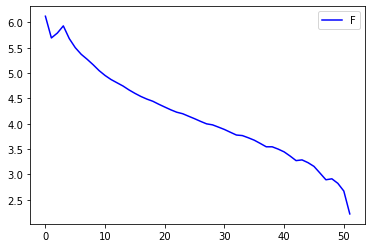

In [16]:
# Converence to the optimal value  in log scale 
plt.plot(np.arange(len(out)-1),np.log10(np.array(np.abs(out[:-1]-out[-1]) )),'b')
plt.legend('FW', loc = 'upper right')